# 🍷 Wine Quality Prediction on Imbalanced Dataset

This notebook presents a machine learning pipeline for predicting wine quality (binary classification) using a highly imbalanced dataset. The project focuses on:

- Handling **class imbalance** (SMOTE + Random Undersampling)
- Applying **PCA** for dimensionality reduction
- Comparing several **classification models** (Random Forest, SVM, Gradient Boosting, etc.)
- Evaluating models based on the **F1 Score**

> Final objective: build a robust classifier that effectively detects minority class samples while maintaining strong overall performance.

---

📁 **Main Steps:**
1. Data Exploration & Preprocessing  
2. Resampling (SMOTE + Undersampling)  
3. PCA Dimensionality Reduction  
4. Model Training & Hyperparameter Tuning  
5. Evaluation on Test Set  
6. Final Model Selection  


# Setting up the environment

In [1]:
# Global
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Set Params
from IPython.display import display, HTML
colormap = sns.diverging_palette(240, 10,n=9, as_cmap = True)
sns.set()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
df = pd.read_csv("/kaggle/input/wine-quality-red-and-white/WineQuality/winequality-red.csv", delimiter=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


# EDA
## Univariate Analysis

quality,5,6,7,4,8,3
count,681,638,199,53,18,10


<Axes: xlabel='quality', ylabel='count'>

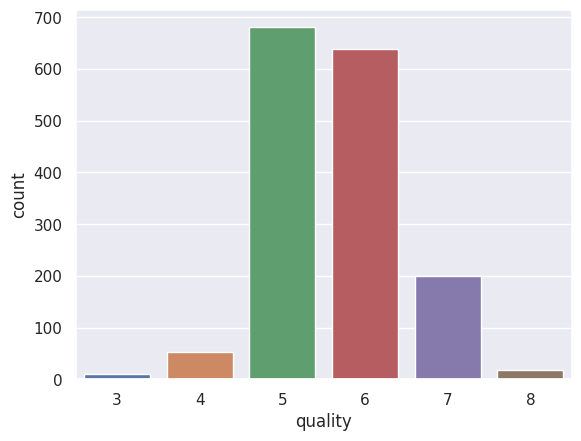

In [5]:
display(df.quality.value_counts().to_frame().T)
sns.countplot(df, x="quality")

### Class Imbalance and Target Transformation

Given the distribution of wine quality scores, the dataset appears to be imbalanced, with most samples concentrated around quality ratings of **5** and **6**. In such cases, it is common to encounter class imbalance issues during classification tasks.

We chose to transform the target variable into a **binary classification problem**:

* **Positive class**: high-quality wines (quality rating of **7** or **8**)
* **Negative class**: all other wines

#### **Advantages**:

1. **Simplicity**: Binary classification problems are generally easier to model and interpret.
2. **Handling imbalance**: Binary classification can be more robust when there is a significant imbalance between classes.

#### **Drawbacks**:

1. **Information loss**: Grouping quality scores into two categories may result in a loss of nuanced information about wine quality differences.

quality,0,1
count,1382,217


<Axes: xlabel='quality', ylabel='count'>

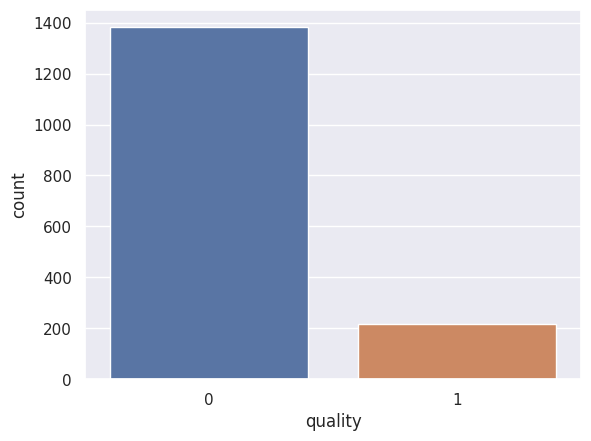

In [6]:
df['quality'] = df['quality'].apply(lambda x: 1 if x in [7, 8] else 0)
display(df.quality.value_counts().to_frame().T)
sns.countplot(df, x="quality")

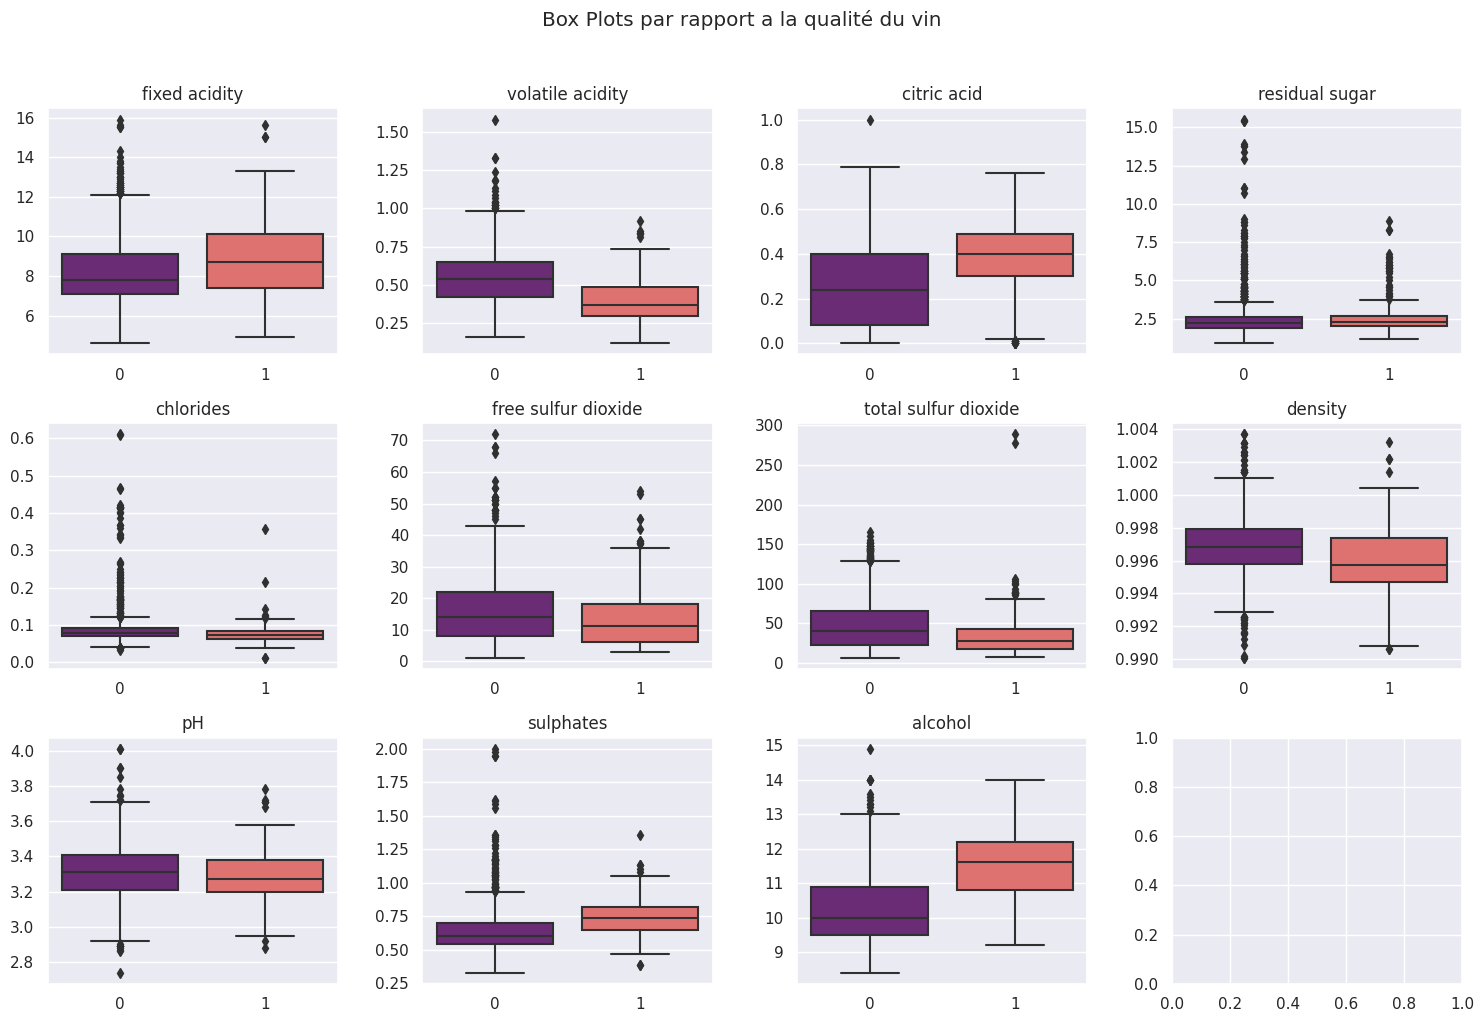

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
fig.suptitle('Box Plots par rapport a la qualité du vin', y=1.02)

# Flatten the 3x4 array of subplots for easier iteration
axes = axes.flatten()

# Loop through selected columns and plot box plots with hue
for i, column in enumerate(df.columns[:-1]):
    sns.boxplot(data=df, x='quality', y=column, ax=axes[i], palette='magma')
    axes[i].set_title(column)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel(None)  # Remove y-axis label for better layout

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


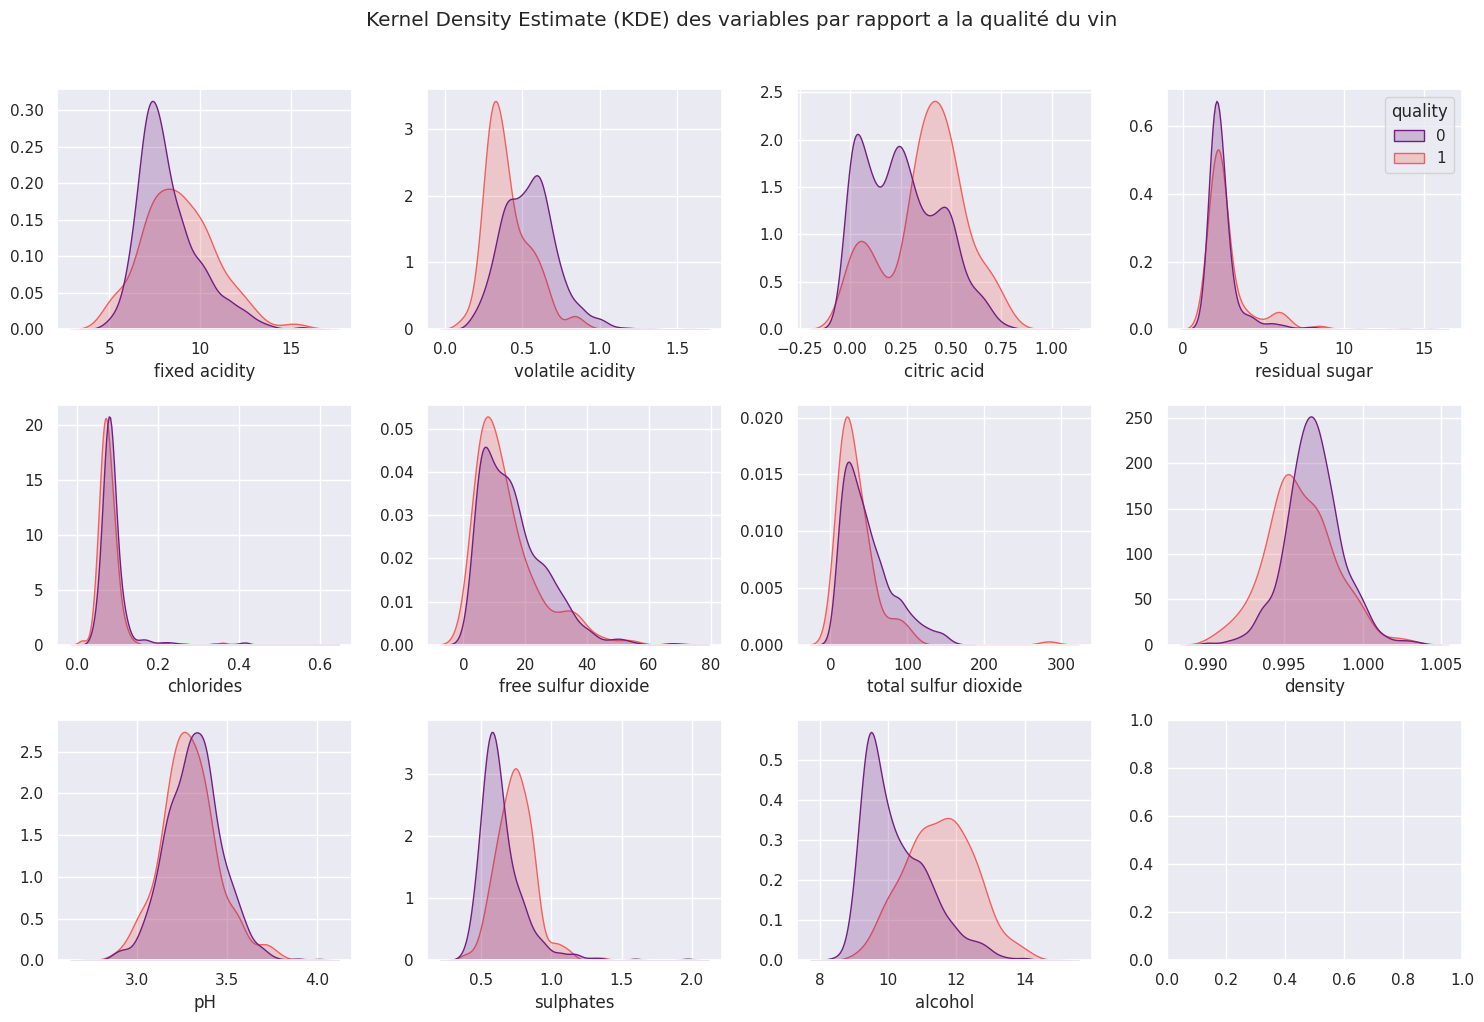

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
fig.suptitle('Kernel Density Estimate (KDE) des variables par rapport a la qualité du vin', y=1.02)

axes = axes.flatten()

for i, column in enumerate(df.columns[:-1]):
    if i == 3:
        legend=True
    else:
        legend=False

    sns.kdeplot(data=df, x=column, hue='quality', fill=True, legend=legend, ax=axes[i], common_norm=False, palette='magma')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel(None)

plt.tight_layout()
plt.show()

### Feature Importance & Distribution Insights

Features showing distinct KDE (Kernel Density Estimate) shapes for different quality levels are likely to be more predictive of wine quality.

* Variables such as **alcohol**, **volatile acidity**, **citric acid**, and **sulphates** are likely key predictors of wine quality.
* Variables like **residual sugar**, **chlorides**, **total sulfur dioxide**, and **sulphates** may contain extreme values that need further examination.

## Multivariate

In [9]:
def correlation_heatmap(df, fig=20, annot=None, filtering=None,sort=True,name='Title', title='Pearson Correlation of Features'):
    """
    Create a correlation matrix with respect to the most correlated variables, and the ability 
    to filter the correlation matrix by pourcentage between 0-1"""
    if sort == True:
        cols1=[]
        cols2=[]
        value=[]
        matrix = df.corr()
        for i in range(len(matrix.columns)):
            for j in range(i):
                cols1.append(matrix.columns[i])
                cols2.append(matrix.columns[j])
                value.append(matrix.iloc[i,j])
        new_df = pd.DataFrame({'column_name_1': cols1, 'column_name_2': cols2, 'corr':value})
        new_df.sort_values('corr',ascending=False, inplace=True)
    
        if filtering != None:
            new_df = new_df[(abs(new_df['corr']) >= filtering)]
    
        all_cols = []
        cols = []
        for index, row in new_df.iterrows():
            all_cols.append(row.column_name_1)
            all_cols.append(row.column_name_2)
        for col in all_cols:
            if col not in cols:
                cols.append(col)
        final = df[cols]
    else:
        final = df.copy()
    _ , ax = plt.subplots(figsize =(fig, fig))
    colormap = sns.diverging_palette(240, 10,n=9, as_cmap = True)
    
    if annot == None:
        if len(final.select_dtypes('number').columns) <= 15:
            annot = True
        else:
            annot = False
    
    _ = sns.heatmap(
        final.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=annot, 
        linewidths=0.1,
        vmin=-1, 
        vmax=1.0, 
        linecolor='white',
        annot_kws={'fontsize':8 }
    )
    
    plt.title(title, y=1.05, size=15)
    if name == 'title':
        name = str(tittle)
    #plt.savefig(name+".png",transparent=True)

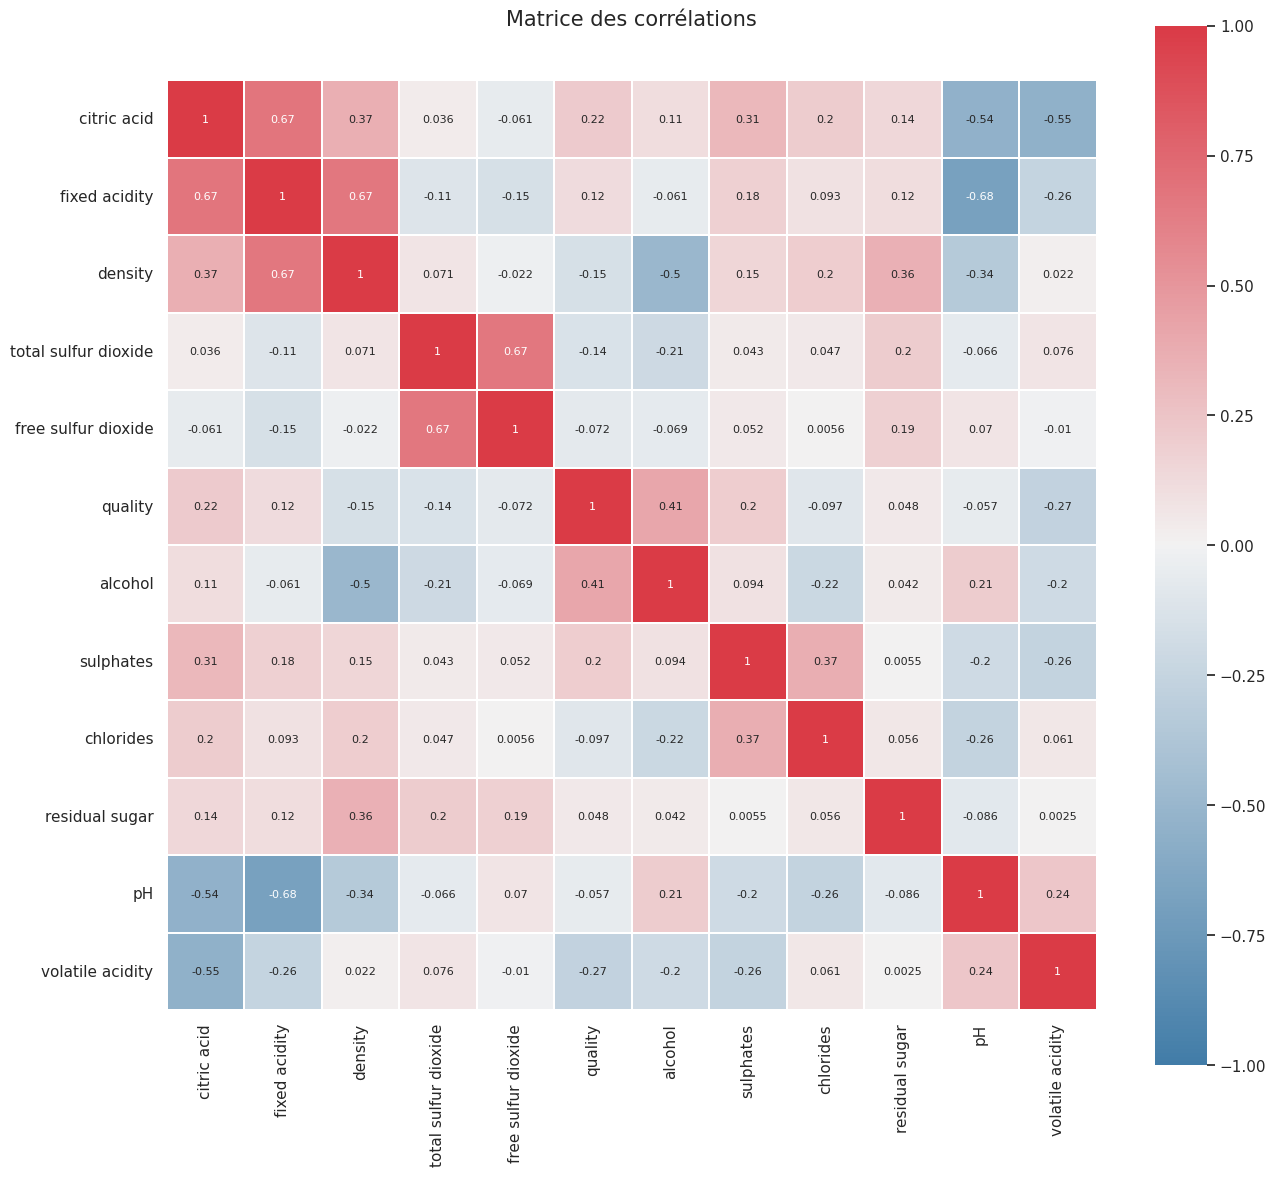

In [10]:
correlation_heatmap(df.iloc[:-1], sort=True, title='Matrice des corrélations', name='corr_all_features', annot=True, fig=15)

### **Correlation Analysis Summary**

#### **Acidity and pH**:

* **Fixed acidity** is strongly positively correlated with **density** and strongly negatively correlated with **pH**.
* **Citric acid** is also positively correlated with fixed acidity.

This suggests that wines with higher fixed acidity tend to have higher density and lower pH. Also, citric acid levels tend to rise with fixed acidity.

#### **Sulfur Dioxide**:

* **Free sulfur dioxide** and **total sulfur dioxide** show a moderate positive correlation.
* Total sulfur dioxide shows a moderate negative correlation with pH.

These results indicate that sulfur dioxide levels are moderately linked and tend to decrease as pH increases.

#### **Alcohol and Density**:

* **Alcohol** shows a moderate positive correlation with **density**.
* Density is also strongly positively correlated with fixed acidity.

This suggests that wines with higher alcohol content tend to be denser, and density increases significantly with fixed acidity.

#### **Volatile Acidity and Citric Acid**:

* Strong negative correlation between **volatile acidity** and **citric acid**.

As volatile acidity increases, citric acid tends to decrease.

#### **Chlorides and Sulphates**:

* **Chlorides** and **sulphates** show a moderate positive correlation, indicating a relationship between these two variables.

In [11]:
# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = df.iloc[:,:-1].columns
vif_data["VIF"] = [variance_inflation_factor(df.iloc[:,:-1].values, i) for i in range(df.iloc[:,:-1].shape[1])]

vif_data.sort_values(by = 'VIF', ascending=False)

,Variable,VIF
7,density,1479.287209
8,pH,1070.967685
10,alcohol,124.394866
0,fixed acidity,74.452265
9,sulphates,21.590621
1,volatile acidity,17.060026
2,citric acid,9.183495
4,chlorides,6.554877
6,total sulfur dioxide,6.519699
5,free sulfur dioxide,6.442682


### Multicollinearity

The correlation matrix highlights some relatively high correlations (e.g., +0.67 and -0.68), indicating the presence of **multicollinearity**, which can affect the **stability and interpretability** of machine learning models.

By computing the **Variance Inflation Factor (VIF)**:

* Variables like **fixed acidity**, **density**, **pH**, and **alcohol** show **extremely high VIFs** (between 74 and 1400), indicating strong multicollinearity.
* Other variables like **volatile acidity** and **sulphates** also show significant VIFs (>10), suggesting moderate multicollinearity.

To address this issue, techniques like **dimensionality reduction**, **feature selection**, or **regularization** should be considered.

# Data Preprocessing

### Data Cleaning: Duplicates

Approximately **15%** of the dataset entries are duplicates, which do not add any new information to the study. Duplicates can introduce bias and reduce the reliability and performance of machine learning models.

→ We chose to **remove duplicates** to avoid these problems.

In [12]:
df.duplicated().sum() / df.shape[0] * 100

15.0093808630394

In [13]:
df = df.drop_duplicates()
df.shape

(1359, 12)

In [14]:
X = df.iloc[:,:-1]
y = df["quality"]

### Data Splitting

The dataset was split into **training and testing sets** to evaluate model performance on unseen data, ensuring fair assessment.

* A **stratified split** was used to maintain the class distribution in both training and test sets, addressing the imbalance issue.
* The **`random_state`** parameter was set for reproducibility.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=23)

### Standardization

A **standardization step** was applied to both training and test sets to ensure uniform scaling of features, which is essential before applying **Principal Component Analysis (PCA)**.

* Standardization was performed **independently** on each set to prevent **data leakage**

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Principal Component Analysis (PCA)

PCA was used to **decorrelate** highly correlated features and to reduce dataset dimensionality.

* This step helps summarize the data into a few principal components, simplifying the model while retaining most of the information.
* PCA also helps reduce noise, potentially improving the quality of the training set.

In [17]:
pca = PCA(n_components=11)  # Adjust the number of components
X_train_pca = pca.fit_transform(X_train_scaled)

In [18]:
X_test_pca = pca.transform(X_test_scaled)

In [19]:
explained_variance_ratio = pca.explained_variance_ratio_
s=0
for i, var in enumerate(explained_variance_ratio, start=1):
    s+=var
    print(f'Component {i}: {var*100:.2f}%,       Cumulative var: {s*100:.2f}%')
print("-"*25)
print(f"Cumulative Ratio: {explained_variance_ratio.sum()*100:.2f}%")

Component 1: 28.50%,       Cumulative var: 28.50%
Component 2: 17.46%,       Cumulative var: 45.96%
Component 3: 14.22%,       Cumulative var: 60.18%
Component 4: 11.03%,       Cumulative var: 71.21%
Component 5: 8.74%,       Cumulative var: 79.95%
Component 6: 5.83%,       Cumulative var: 85.78%
Component 7: 5.34%,       Cumulative var: 91.11%
Component 8: 3.54%,       Cumulative var: 94.65%
Component 9: 3.14%,       Cumulative var: 97.80%
Component 10: 1.65%,       Cumulative var: 99.45%
Component 11: 0.55%,       Cumulative var: 100.00%
-------------------------
Cumulative Ratio: 100.00%


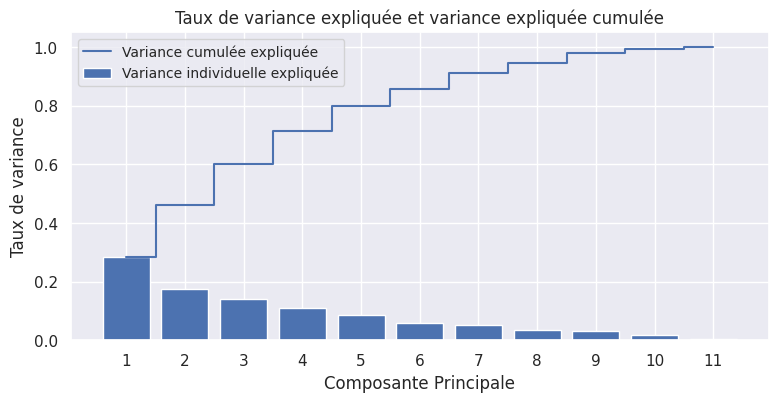

In [20]:
# Plot explained variance ratio for each component
plt.figure(figsize=(9, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, align='center', label='Variance individuelle expliquée')
plt.step(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), where='mid', label='Variance cumulée expliquée')

plt.title('Taux de variance expliquée et variance expliquée cumulée')
plt.xlabel('Composante Principale')
plt.ylabel('Taux de variance')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend(fontsize='small')
plt.show()

### Model Optimization

To determine the **optimal number of components** and improve model performance, we applied **Grid Search** and **Cross-Validation**, testing various hyperparameter combinations.

## Resampling

### Class Imbalance

Imbalanced classification involves developing predictive models on datasets where one class is significantly underrepresented. In our case, **86%** of the records belong to class "0" (meaning "No"), while only **14%** belong to class "1" (meaning "Yes").

Working with imbalanced datasets poses a significant challenge, as most machine learning algorithms tend to ignore the minority class. This leads to poor performance in detecting that class, which is often the most important in practice.

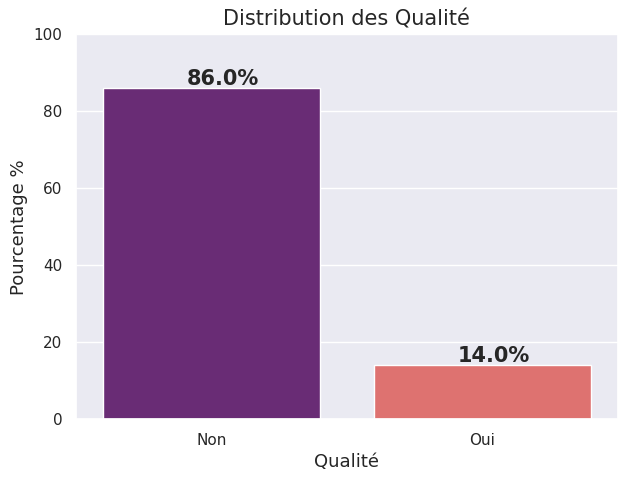

In [21]:
pourc = ((y_train.value_counts()/len(y_train)*100)
         .to_frame()
         .round()
         .reset_index()
         .rename(columns={'count':'pourcentage'})
)
pourc.quality = pourc.quality.map({0:'Non', 1:'Oui'})

f,ax = plt.subplots(1, figsize=(7,5))
ax = sns.barplot(data = pourc, x='quality', y='pourcentage', errorbar=None ,orient='v', palette='magma' )
ax.set(ylim=(0, 100))
ax.set_title("Distribution des Qualité", fontsize=15)
ax.set_xlabel ("Qualité",fontsize=13)
ax.set_ylabel ("Pourcentage %",fontsize=13)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2-0.09,rect.get_height()+0.9,"%.1f%%"% rect.get_height(), weight='bold',fontsize=15 )

### Resampling

There are two main approaches to balancing a dataset:

* **Oversampling** the minority class.
* **Undersampling** the majority class.

In this study, we adopt the **SMOTE (Synthetic Minority Oversampling Technique)** approach, which is known to yield strong results, especially when combined with **random undersampling** of the majority class (as recommended in the original SMOTE research paper).

To select the best resampling strategy, we used **Grid Search** and **Cross-Validation** for parameter optimization.

To determine the optimal number of components and the best resampling strategy, we implemented hyperparameter optimization using Grid Search with Cross-Validation. The chosen model is a **RandomForestClassifier**, and the optimization criterion is the **F1 score**.

The parameter search space includes:

* **SMOTE (Oversampling)**: \[0.4, 0.5, 0.6]
* **Random Undersampling**: \[0.7, 0.8, 0.9]
* **n\_estimators**: \[50, 100] — Number of trees in the forest
* **max\_depth**: \[None, 10] — Maximum tree depth
* **min\_samples\_split**: \[2, 10] — Minimum samples required to split an internal node
* **min\_samples\_leaf**: \[1, 3] — Minimum samples required to be a leaf node

We instantiated SMOTE, Random Undersampling, and Random Forest components with the defined configurations. A loop was run varying the number of PCA components from 2 to 11, applying a pipeline with all three components at each iteration.

**GridSearchCV** was used to tune the model's hyperparameters using stratified 5-fold cross-validation. For each iteration, we recorded the number of components, F1 score, and the best parameters for SMOTE and undersampling.

Random Forest was chosen for its ability to capture nonlinear relationships and robustness in high-dimensional spaces, making it ideal for datasets with many components.

F1 score was selected as the optimization criterion due to the dataset's imbalanced nature. Unlike accuracy, which may be biased toward the majority class, F1 considers both false positives and false negatives, making it more appropriate for this context.

In [22]:
cols = [f"Component {i}" for i in range(1, len(explained_variance_ratio)+1)]
X_train_pca = pd.DataFrame(X_train_pca, columns=cols)
X_test_pca = pd.DataFrame(X_test_pca, columns=cols)

In [25]:
%%time

# Define parameters for Random Forest
rf_params = {
    'smote__sampling_strategy': [0.4, 0.5, 0.6],
    'under__sampling_strategy': [0.7, 0.8, 0.9],
    'model__n_estimators': [50, 100],
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2, 10],
    'model__min_samples_leaf': [1, 3]
}

# Initialize SMOTE, RandomUnderSampler, and RandomForestClassifier
smote = SMOTE(random_state=23)
under = RandomUnderSampler(random_state=23)
rf_model = RandomForestClassifier(random_state=23, n_jobs=-1)

n_comp = []
train_f1 = []
smote_ = []
under_ = []

for i in range(2, 12):
    X_train_pca_loop = X_train_pca.iloc[:, :i].copy()
    X_test_pca_loop = X_test_pca.iloc[:, :i].copy()

    # Create the pipeline with Random Forest
    pipe = Pipeline(steps=[
        ('smote', smote),
        ('under', under),
        ('model', rf_model)
    ])

    # GridSearchCV for hyperparameter tuning
    rf_cv_model = GridSearchCV(pipe, rf_params, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=23), scoring='f1', n_jobs=-1)
    rf_cv_model.fit(X_train_pca_loop, y_train)

    # Append results to lists
    n_comp.append(i)
    train_f1.append(rf_cv_model.best_score_)
    smote_.append(rf_cv_model.best_params_["smote__sampling_strategy"])
    under_.append(rf_cv_model.best_params_["under__sampling_strategy"])

    # Print or use the results as needed
    print("____________________________________________")
    print("Metric: F1 score     Number of components:", i)
    print(f"CV: {rf_cv_model.best_score_:.4f} \nparams: {rf_cv_model.best_params_}")

____________________________________________
Metric: F1 score     Number of components: 2
CV: 0.3977 
params: {'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 10, 'model__n_estimators': 100, 'smote__sampling_strategy': 0.6, 'under__sampling_strategy': 0.8}
____________________________________________
Metric: F1 score     Number of components: 3
CV: 0.5127 
params: {'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 50, 'smote__sampling_strategy': 0.4, 'under__sampling_strategy': 0.7}
____________________________________________
Metric: F1 score     Number of components: 4
CV: 0.5131 
params: {'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 10, 'model__n_estimators': 50, 'smote__sampling_strategy': 0.6, 'under__sampling_strategy': 0.7}
____________________________________________
Metric: F1 score     Number of components: 5
CV: 0.5219 
params: {'model__max_depth':

In [87]:
rank = pd.DataFrame({'n components': n_comp,'F1': train_f1, 'SMOTE': smote_, 'Under': under_})
rank = rank.sort_values("F1", ascending=False).set_index('n components', drop=True)
rank

,F1,SMOTE,Under
n components,,,
10,0.536570,0.4,0.9
8,0.531184,0.4,0.8
7,0.530404,0.5,0.7
9,0.527190,0.6,0.8
11,0.526080,0.4,0.9
5,0.521908,0.6,0.7
6,0.519758,0.6,0.7
4,0.513129,0.6,0.7
3,0.512667,0.4,0.7


Based on our experience and results, using **10** components yielded the highest performance. The best-performing parameters were:

**Resampling Strategy:**

* SMOTE with a ratio of **0.4**
* Random Undersampling with a ratio of **0.9**

These results suggest that combining synthetic oversampling of the minority class with random undersampling of the majority class leads to optimal model performance.

# Model Selection

We used a methodical approach by applying multiple machine learning algorithms on the training set. For each model, we performed hyperparameter optimization using Grid Search with 10-fold cross-validation. Despite the small dataset, we chose 10 folds to ensure robust and reliable results. The evaluation criterion was the **F1 score**.

Each model used the same resampling strategy: **SMOTE with a ratio of 0.6** and **Random Undersampling with a ratio of 0.6**, as previously selected via cross-validation.

In [27]:
X_cv = X_train_pca.iloc[:, :11].copy()
y_cv = y_train.copy()

algo = []
acc = []
perc = []
rec = []
f1 = []
std_f1 = []
parm = []

model = None

cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=23)

scoring = ['accuracy','precision', 'recall', 'f1']

smote = SMOTE(sampling_strategy=0.4, random_state=23)
under = RandomUnderSampler(sampling_strategy=0.9, random_state=23)

### Logistic Regression

In [28]:
%%time
model = LogisticRegression(random_state=23)

pipe = Pipeline(steps=[
    ('smote', smote),
    ('under', under),
    ('model', model)
])

logreg_params = {
    "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "model__penalty": ["l1", "l2"], #l1 pour lasso et l2 pour ridge
    "model__solver": ["saga"]
}

logreg_cv_model = GridSearchCV(pipe, logreg_params, cv=cv, scoring='f1', n_jobs=-1)
logreg_cv_model.fit(X_cv, y_cv)

model = LogisticRegression(C=logreg_cv_model.best_params_["model__C"],
                                  penalty=logreg_cv_model.best_params_["model__penalty"],
                                  solver=logreg_cv_model.best_params_["model__solver"],
                                  random_state=23)

pipe = Pipeline(steps=[ ('smote', smote), ('under', under), ('model', model)])

cv_results  = cross_validate(pipe, X_cv, y_cv, cv=cv, scoring=scoring, n_jobs=-1)

algo.append("Logistic Regression")
acc.append(cv_results['test_accuracy'].mean())
perc.append(cv_results['test_precision'].mean())
rec.append(cv_results['test_recall'].mean())
f1.append(cv_results['test_f1'].mean())
std_f1.append(cv_results['test_f1'].std())
parm.append(logreg_cv_model.best_params_)

print(("-" *10) + "CV results " + ("-" *10))
print(f"accuracy: {cv_results['test_accuracy'].mean():.4f} \nprecision: {cv_results['test_precision'].mean():.4f} \nrecall: {cv_results['test_recall'].mean():.4f} \nf1 mean: {cv_results['test_f1'].mean():.4f} \nf1 std: {cv_results['test_f1'].std():.4f}")
print(f"params: {logreg_cv_model.best_params_}")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

----------CV results ----------
accuracy: 0.7967 
precision: 0.3776 
recall: 0.7616 
f1 mean: 0.5046 
f1 std: 0.0518
params: {'model__C': 100, 'model__penalty': 'l1', 'model__solver': 'saga'}
CPU times: user 206 ms, sys: 8.66 ms, total: 214 ms
Wall time: 853 ms


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## KNN

In [29]:
%%time
model = KNeighborsClassifier()

pipe = Pipeline(steps=[('smote', smote),('under', under),('model', model)])

knn_params = {
    "model__n_neighbors": np.arange(2, 50),
    "model__weights": ["uniform", "distance"],
    "model__leaf_size": [25, 30, 25]
}

knn_cv_model = GridSearchCV(pipe, knn_params, cv=cv, scoring='f1', n_jobs=-1)
knn_cv_model.fit(X_cv, y_cv)

model = KNeighborsClassifier(n_neighbors=knn_cv_model.best_params_["model__n_neighbors"],
                             leaf_size=knn_cv_model.best_params_["model__leaf_size"],
                             weights=knn_cv_model.best_params_["model__weights"])

pipe = Pipeline(steps=[ ('smote', smote), ('under', under), ('model', model)])

cv_results  = cross_validate(pipe, X_cv, y_cv, cv=cv, scoring=scoring, n_jobs=-1)

algo.append("K Nearest Neighbors")
acc.append(cv_results['test_accuracy'].mean())
perc.append(cv_results['test_precision'].mean())
rec.append(cv_results['test_recall'].mean())
f1.append(cv_results['test_f1'].mean())
std_f1.append(cv_results['test_f1'].std())
parm.append(logreg_cv_model.best_params_)

print(("-" *10) + "K Nearest Neighbors CV results " + ("-" *10))
print(f"accuracy: {cv_results['test_accuracy'].mean():.4f} \nprecision: {cv_results['test_precision'].mean():.4f} \nrecall: {cv_results['test_recall'].mean():.4f} \nf1 mean: {cv_results['test_f1'].mean():.4f} \nf1 std: {cv_results['test_f1'].std():.4f}")
print(f"params: {logreg_cv_model.best_params_}")

----------K Nearest Neighbors CV results ----------
accuracy: 0.7525 
precision: 0.3307 
recall: 0.8092 
f1 mean: 0.4687 
f1 std: 0.0139
params: {'model__C': 100, 'model__penalty': 'l1', 'model__solver': 'saga'}
CPU times: user 2.64 s, sys: 104 ms, total: 2.75 s
Wall time: 19 s


## SVM

In [30]:
%%time
model = SVC(random_state=23)

pipe = Pipeline(steps=[('smote', smote),('under', under),('model', model)])

svm_params = {
    "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "model__kernel": ["linear", "rbf"],
    "model__gamma": ["scale", "auto"],
}

svm_cv_model = GridSearchCV(pipe, svm_params, cv=cv, scoring='f1', n_jobs=-1)
svm_cv_model.fit(X_cv, y_cv)

# Refit with the best model

model = SVC(C=svm_cv_model.best_params_["model__C"],
                             kernel=svm_cv_model.best_params_["model__kernel"],
                             gamma=svm_cv_model.best_params_["model__gamma"],
                             random_state=23)

pipe = Pipeline(steps=[ ('smote', smote), ('under', under), ('model', model)])

cv_results = cross_validate(pipe, X_cv, y_cv, cv=cv, scoring=scoring, n_jobs=-1)

algo.append("SVM")
acc.append(cv_results['test_accuracy'].mean())
perc.append(cv_results['test_precision'].mean())
rec.append(cv_results['test_recall'].mean())
f1.append(cv_results['test_f1'].mean())
std_f1.append(cv_results['test_f1'].std())
parm.append(svm_cv_model.best_params_)

print(("-" * 10) + "SVM CV results " + ("-" * 10))
print(f"accuracy: {cv_results['test_accuracy'].mean():.4f} \nprecision: {cv_results['test_precision'].mean():.4f} \nrecall: {cv_results['test_recall'].mean():.4f} \nf1 mean: {cv_results['test_f1'].mean():.4f} \nf1 std: {cv_results['test_f1'].std():.4f}")
print(f"params: {svm_cv_model.best_params_}")

----------SVM CV results ----------
accuracy: 0.8160 
precision: 0.4032 
recall: 0.7483 
f1 mean: 0.5239 
f1 std: 0.0156
params: {'model__C': 1, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
CPU times: user 324 ms, sys: 18.2 ms, total: 343 ms
Wall time: 4.85 s


## Random Forest

In [31]:
%%time
model = RandomForestClassifier(random_state=23)

pipe = Pipeline(steps=[('smote', smote),('under', under),('model', model)])

rf_params = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

rf_cv_model = GridSearchCV(pipe, rf_params, cv=cv, scoring='f1', n_jobs=-1)
rf_cv_model.fit(X_cv, y_cv)

# Refit with the best model
model = RandomForestClassifier(n_estimators=rf_cv_model.best_params_["model__n_estimators"],
                             max_depth=rf_cv_model.best_params_["model__max_depth"],
                             min_samples_split=rf_cv_model.best_params_["model__min_samples_split"],
                             min_samples_leaf=rf_cv_model.best_params_["model__min_samples_leaf"],
                             random_state=23)

pipe = Pipeline(steps=[('smote', smote),('under', under),('model', model)])

cv_results = cross_validate(pipe, X_cv, y_cv, cv=cv, scoring=scoring, n_jobs=-1)

algo.append("Random Forest")
acc.append(cv_results['test_accuracy'].mean())
perc.append(cv_results['test_precision'].mean())
rec.append(cv_results['test_recall'].mean())
f1.append(cv_results['test_f1'].mean())
std_f1.append(cv_results['test_f1'].std())
parm.append(rf_cv_model.best_params_)

print(("-" * 10) + "Random Forest CV results " + ("-" * 10))
print(f"accuracy: {cv_results['test_accuracy'].mean():.4f} \nprecision: {cv_results['test_precision'].mean():.4f} \nrecall: {cv_results['test_recall'].mean():.4f} \nf1 mean: {cv_results['test_f1'].mean():.4f} \nf1 std: {cv_results['test_f1'].std():.4f}")
print(f"params: {rf_cv_model.best_params_}")

----------Random Forest CV results ----------
accuracy: 0.8372 
precision: 0.4351 
recall: 0.6740 
f1 mean: 0.5279 
f1 std: 0.0390
params: {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 50}
CPU times: user 2.89 s, sys: 224 ms, total: 3.12 s
Wall time: 1min 23s


## Gradient Boosting

In [32]:
%%time
model = GradientBoostingClassifier(random_state=23)

pipe = Pipeline(steps=[('smote', smote),('under', under),('model', model)])

gb_params = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [3, 5, 7],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

gb_cv_model = GridSearchCV(pipe, gb_params, cv=cv, scoring='f1', n_jobs=-1)
gb_cv_model.fit(X_cv, y_cv)

# Refit with the best model
model = GradientBoostingClassifier(n_estimators=gb_cv_model.best_params_["model__n_estimators"],
                                   max_depth=gb_cv_model.best_params_["model__max_depth"],
                                   min_samples_split=gb_cv_model.best_params_["model__min_samples_split"],
                                   min_samples_leaf=gb_cv_model.best_params_["model__min_samples_leaf"],
                                   random_state=23)

pipe = Pipeline(steps=[('smote', smote),('under', under),('model', model)])

cv_results = cross_validate(pipe, X_cv, y_cv, cv=cv, scoring=scoring, n_jobs=-1)

algo.append("Gradient Boosting")
acc.append(cv_results['test_accuracy'].mean())
perc.append(cv_results['test_precision'].mean())
rec.append(cv_results['test_recall'].mean())
f1.append(cv_results['test_f1'].mean())
std_f1.append(cv_results['test_f1'].std())
parm.append(gb_cv_model.best_params_)

print(("-" * 10) + "Gradient Boosting CV results " + ("-" * 10))
print(f"accuracy: {cv_results['test_accuracy'].mean():.4f} \nprecision: {cv_results['test_precision'].mean():.4f} \nrecall: {cv_results['test_recall'].mean():.4f} \nf1 mean: {cv_results['test_f1'].mean():.4f} \nf1 std: {cv_results['test_f1'].std():.4f}")
print(f"params: {gb_cv_model.best_params_}")

----------Gradient Boosting CV results ----------
accuracy: 0.8160 
precision: 0.3979 
recall: 0.7007 
f1 mean: 0.5071 
f1 std: 0.0305
params: {'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 50}
CPU times: user 2.41 s, sys: 245 ms, total: 2.65 s
Wall time: 1min 39s


## LGBM

In [33]:
%%time
model = LGBMClassifier(random_state=23)

pipe = Pipeline(steps=[('smote', smote),('under', under),('model', model)])

lgbm_params = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [None, 10, 20, 30],
    "model__learning_rate": [0.001, 0.01, 0.1],
    "model__subsample": [0.8, 0.9, 1.0]
}

lgbm_cv_model = GridSearchCV(pipe, lgbm_params, cv=cv, scoring='f1', n_jobs=-1)
lgbm_cv_model.fit(X_cv, y_cv)

# Refit with the best model
model = LGBMClassifier(n_estimators=lgbm_cv_model.best_params_["model__n_estimators"],
                             max_depth=lgbm_cv_model.best_params_["model__max_depth"],
                             learning_rate=lgbm_cv_model.best_params_["model__learning_rate"],
                             subsample=lgbm_cv_model.best_params_["model__subsample"],
                             random_state=23)

pipe = Pipeline(steps=[('smote', smote),('under', under),('model', model)])

cv_results = cross_validate(pipe, X_cv, y_cv, cv=cv, scoring=scoring, n_jobs=-1)

algo.append("LightGBM")
acc.append(cv_results['test_accuracy'].mean())
perc.append(cv_results['test_precision'].mean())
rec.append(cv_results['test_recall'].mean())
f1.append(cv_results['test_f1'].mean())
std_f1.append(cv_results['test_f1'].std())
parm.append(lgbm_cv_model.best_params_)

print(("-" * 10) + "LightGBM CV results " + ("-" * 10))
print(f"accuracy: {cv_results['test_accuracy'].mean():.4f} \nprecision: {cv_results['test_precision'].mean():.4f} \nrecall: {cv_results['test_recall'].mean():.4f} \nf1 mean: {cv_results['test_f1'].mean():.4f} \nf1 std: {cv_results['test_f1'].std():.4f}")
print(f"params: {lgbm_cv_model.best_params_}")

----------LightGBM CV results ----------
accuracy: 0.8031 
precision: 0.3823 
recall: 0.7202 
f1 mean: 0.4984 
f1 std: 0.0542
params: {'model__learning_rate': 0.01, 'model__max_depth': None, 'model__n_estimators': 200, 'model__subsample': 0.8}
CPU times: user 7.36 s, sys: 3.54 s, total: 10.9 s
Wall time: 1min 28s


## XGB

In [34]:
%%time
model = XGBClassifier(random_state=23)

pipe = Pipeline(steps=[('smote', smote),('under', under),('model', model)])

xgb_params = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [3, 5, 7, 10],
    "model__learning_rate": [0.001, 0.01, 0.1],
    "model__subsample": [0.8, 0.9, 1.0]
}

xgb_cv_model = GridSearchCV(pipe, xgb_params, cv=cv, scoring='f1', n_jobs=-1)
xgb_cv_model.fit(X_cv, y_cv)

# Refit with the best model
model = XGBClassifier(n_estimators=xgb_cv_model.best_params_["model__n_estimators"],
                             max_depth=xgb_cv_model.best_params_["model__max_depth"],
                             learning_rate=xgb_cv_model.best_params_["model__learning_rate"],
                             subsample=xgb_cv_model.best_params_["model__subsample"],
                             random_state=23,
                             n_jobs=-1)

pipe = Pipeline(steps=[('smote', smote),('under', under),('model', model)])

cv_results = cross_validate(pipe, X_cv, y_cv, cv=cv, scoring=scoring, n_jobs=-1)

algo.append("XGBoost")
acc.append(cv_results['test_accuracy'].mean())
perc.append(cv_results['test_precision'].mean())
rec.append(cv_results['test_recall'].mean())
f1.append(cv_results['test_f1'].mean())
std_f1.append(cv_results['test_f1'].std())
parm.append(xgb_cv_model.best_params_)

print(("-" * 10) + "XGBoost CV results " + ("-" * 10))
print(f"accuracy: {cv_results['test_accuracy'].mean():.4f} \nprecision: {cv_results['test_precision'].mean():.4f} \nrecall: {cv_results['test_recall'].mean():.4f} \nf1 mean: {cv_results['test_f1'].mean():.4f} \nf1 std: {cv_results['test_f1'].std():.4f}")
print(f"params: {xgb_cv_model.best_params_}")

----------XGBoost CV results ----------
accuracy: 0.8233 
precision: 0.4071 
recall: 0.6729 
f1 mean: 0.5069 
f1 std: 0.0451
params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
CPU times: user 2min 10s, sys: 2.29 s, total: 2min 12s
Wall time: 2min 12s


In [98]:
data = {
    'Algorithm': algo,
    'Accuracy': acc,
    'Precision': perc,
    'Recall': rec,
    'F1 Score': f1,
    #'F1 Score Std Dev': std_f1,
    'Best Parameters': parm
}

results = pd.DataFrame(data)
results = results.set_index('Algorithm', drop=True)
results = results.sort_values(by= "F1 Score", ascending=False)
display(results.drop('Best Parameters', axis=1))

,Accuracy,Precision,Recall,F1 Score
Algorithm,,,,
Random Forest,0.837154,0.435145,0.674023,0.527882
SVM,0.815998,0.403231,0.748276,0.523902
Gradient Boosting,0.815998,0.397877,0.700690,0.507086
XGBoost,0.823337,0.407081,0.672874,0.506861
Logistic Regression,0.796668,0.377628,0.761609,0.504566
LightGBM,0.803107,0.382274,0.720230,0.498414
K Nearest Neighbors,0.752543,0.330746,0.809195,0.468695


## Results Analysis

The top-performing models — **Random Forest, SVM, and Gradient Boosting** — showed similar results in terms of accuracy, precision, recall, and F1 score. These models demonstrated strong adaptability to the imbalanced dataset.

**Logistic Regression** and **LightGBM** showed intermediate results — acceptable accuracy and precision but slightly lower recall and F1 scores, offering a balance between simplicity and performance.

**K Nearest Neighbors** had high recall (effectively identifying positive samples) but lower precision, reflected in a lower F1 score. This model may be suitable when minimizing false negatives is a priority.

### In conclusion:

Model selection depends on the specific goals of the project. **Random Forest, SVM, and Gradient Boosting** stand out for their versatility and overall performance, warranting further exploration.

# Model Evaluation

This section evaluates the selected models on the **test set** to measure their generalization.

In [89]:
#Preparation
smote = SMOTE(sampling_strategy=0.4, random_state=23) # SMOTE Oversampling
under = RandomUnderSampler(sampling_strategy=0.9, random_state=23) # Random Undersampling

X_train_eval, y_train_eval = smote.fit_resample(X_train_pca.iloc[:, :11].copy(),y_train)
X_train_eval, y_train_eval = under.fit_resample(X_train_eval, y_train_eval)

X_test_eval = X_test_pca.iloc[:, :11]

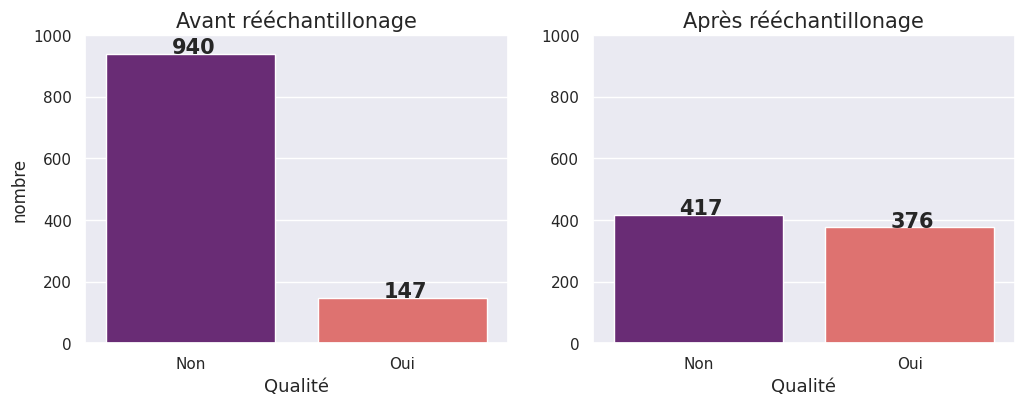

In [90]:
before = ((y_train.value_counts())
         .to_frame()
         .round()
         .reset_index()
         .rename(columns={'count':'nombre'})
)
before.quality = before.quality.map({0:'Non', 1:'Oui'})

after = ((y_train_eval.value_counts())
         .to_frame()
         .round()
         .reset_index()
         .rename(columns={'count':'nombre'})
)
after.quality = after.quality.map({0:'Non', 1:'Oui'})

f,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

sns.barplot(data = before, x='quality', y='nombre', errorbar=None ,orient='v', palette='magma', ax=ax1 )
ax1.set(ylim=(0, 1000))
ax1.set_title("Avant rééchantillonage", fontsize=15)
ax1.set_xlabel ("Qualité",fontsize=13)
#ax.set_ylabel ("Pourcentage %",fontsize=13)
for rect in ax1.patches:
    ax1.text (rect.get_x() + rect.get_width() / 2-0.09,rect.get_height()+0.9,"%.0f"% rect.get_height(), weight='bold',fontsize=15 )
    
sns.barplot(data = after, x='quality', y='nombre', errorbar=None ,orient='v', palette='magma', ax=ax2 )
ax2.set(ylim=(0, 1000))
ax2.set_title("Après rééchantillonage", fontsize=15)
ax2.set_xlabel ("Qualité",fontsize=13)
ax2.set_ylabel (None)
for rect in ax2.patches:
    ax2.text (rect.get_x() + rect.get_width() / 2-0.09,rect.get_height()+0.9,"%.0f"% rect.get_height(), weight='bold',fontsize=15 )

In [91]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

test_results = []

def store_res(model, wine_type, y_true, y_pred, lst):
    classification_rep = classification_report(y_true, y_pred)
    lst.append({
        'Subset': wine_type,
        'Model': model,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
    })
    return classification_rep

## Random  Forest

In [92]:
best_params = results.loc['Random Forest'][4]

rf_model = RandomForestClassifier(n_estimators=best_params["model__n_estimators"],
                             max_depth=best_params["model__max_depth"],
                             min_samples_split=best_params["model__min_samples_split"],
                             min_samples_leaf=best_params["model__min_samples_leaf"],
                             random_state=23)

rf_model.fit(X_train_eval, y_train_eval)
y_pred = rf_model.predict(X_test_eval)


# Classification Report
print("\nRandom Forest Classification Report:")
print(store_res('Random Forest', 'Red', y_test, y_pred, test_results))

# Confusion Matrix
rf_conf_matrix = confusion_matrix(y_test, y_pred, normalize='all')


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       235
           1       0.46      0.70      0.56        37

    accuracy                           0.85       272
   macro avg       0.71      0.79      0.73       272
weighted avg       0.88      0.85      0.86       272



## SVM

In [93]:
best_params = results.loc['SVM'][4]

svm_model = SVC(C=best_params["model__C"],
               kernel=best_params["model__kernel"],
               gamma=best_params["model__gamma"],
               random_state=23)

svm_model.fit(X_train_eval, y_train_eval)
y_pred = svm_model.predict(X_test_eval)


# Classification Report
print("\nSVM Classification Report:")
print(store_res('SVM', 'Red', y_test, y_pred, test_results))

# Confusion Matrix
svm_conf_matrix = confusion_matrix(y_test, y_pred, normalize='all')


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       235
           1       0.50      0.84      0.63        37

    accuracy                           0.86       272
   macro avg       0.74      0.85      0.77       272
weighted avg       0.91      0.86      0.88       272



## Gradient Boosting

In [94]:
best_params = results.loc['Gradient Boosting'][4]

gb_model = GradientBoostingClassifier(n_estimators=best_params["model__n_estimators"],
                                   max_depth=best_params["model__max_depth"],
                                   min_samples_split=best_params["model__min_samples_split"],
                                   min_samples_leaf=best_params["model__min_samples_leaf"],
                                   random_state=23)

gb_model.fit(X_train_eval, y_train_eval)
y_pred = gb_model.predict(X_test_eval)

# Classification Report
print("\nGradient Boosting Classification Report:")
print(store_res('Gradient Boosting', 'Red', y_test, y_pred, test_results))

# Confusion Matrix
gb_conf_matrix = confusion_matrix(y_test, y_pred, normalize='all')


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       235
           1       0.43      0.81      0.57        37

    accuracy                           0.83       272
   macro avg       0.70      0.82      0.73       272
weighted avg       0.89      0.83      0.85       272



In [49]:
best_params = results.loc['XGBoost'][4]

xgb_model = XGBClassifier(n_estimators=best_params["model__n_estimators"],
                             max_depth=best_params["model__max_depth"],
                             learning_rate=best_params["model__learning_rate"],
                             subsample=best_params["model__subsample"],
                             random_state=23,
                             n_jobs=-1)

xgb_model.fit(X_train_eval, y_train_eval)
y_pred = xgb_model.predict(X_test_eval)

# Classification Report
print("\nXGBoost Classification Report:")
print(store_res('XGBoost', 'Red', y_test, y_pred, test_results))

# Confusion Matrix
xgb_conf_matrix = confusion_matrix(y_test, y_pred, normalize='all')


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       235
           1       0.43      0.70      0.53        37

    accuracy                           0.83       272
   macro avg       0.69      0.78      0.71       272
weighted avg       0.88      0.83      0.85       272



,Subset,Accuracy,Precision,Recall,F1
Model,,,,,
SVM,Red,0.8640,0.5000,0.8378,0.6263
Gradient Boosting,Red,0.8309,0.4348,0.8108,0.5660
Random Forest,Red,0.8493,0.4643,0.7027,0.5591


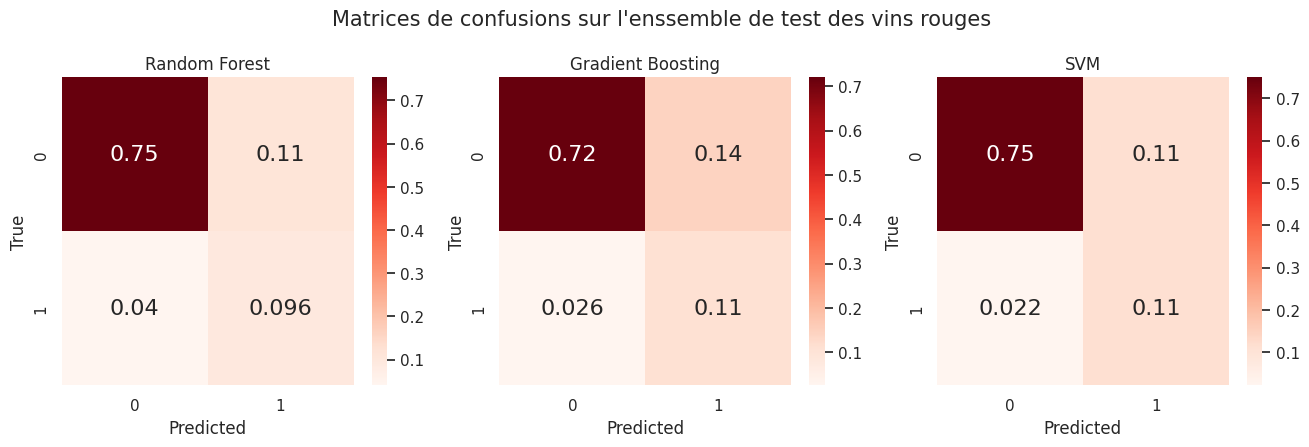

In [95]:
final_test_results = pd.DataFrame(test_results).set_index('Model', drop=True)
final_test_results = (final_test_results
                     .round(4)
                     .sort_values(by='F1', ascending=False))
display(final_test_results)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
fig.suptitle("Matrices de confusions sur l'enssemble de test des vins rouges", y=1.05, size=15)

sns.heatmap(rf_conf_matrix, annot=True, cmap="Reds", annot_kws={"size": 16}, ax=ax1)
ax1.set_title("Random Forest")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")

sns.heatmap(gb_conf_matrix, annot=True, cmap="Reds", annot_kws={"size": 16}, ax=ax2)
ax2.set_title("Gradient Boosting")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True")

sns.heatmap(svm_conf_matrix, annot=True, cmap="Reds", annot_kws={"size": 16}, ax=ax3)
ax3.set_title("SVM")
ax3.set_xlabel("Predicted")
ax3.set_ylabel("True")

plt.show()

In [97]:
final_test_results.to_csv('red_test_results.csv')
final_test_results.to_pickle('red_test_results.pkl')

## Analyse des résultats

### Classification Reports:

#### Random Forest:

* Overall Accuracy: 85%
* Precision for Class 1 (minority): 46%
* Recall for Class 1: 70%
* F1 Score: 56%

#### Gradient Boosting:

* Overall Accuracy: 83%
* Precision for Class 1: 43%
* Recall for Class 1: 81%
* F1 Score: 57%

#### SVM:

* Overall Accuracy: 86%
* Precision for Class 1: 50%
* Recall for Class 1: 84%
* F1 Score: 63%

## Final Conclusion

* While all three models performed well, SVM achieved the best results across all key metrics.

**Best SVM parameters:**

* **Regularization (C)**: 1
* **Kernel**: Gaussian RBF
* **Gamma**: 'auto' (automatically adjusted based on dataset size)

These findings emphasize the importance of choosing a model based on project-specific goals, balancing **precision**, **recall**, or **F1 score** depending on priorities.

# Final Project Summary

This project aimed to build an effective classification model to detect a minority class in an imbalanced dataset. Key steps and takeaways:

1. **Data Exploration:**

   * Revealed significant class imbalance
   * Applied resampling strategies (SMOTE and undersampling) to address it

2. **Preprocessing:**

   * Stratified train-test split maintained class proportions
   * Standardization ensured fair comparison across features

3. **Dimensionality Reduction:**

   * PCA reduced feature space while preserving important variance
   * Helped mitigate multicollinearity and model complexity

4. **Model Selection and Optimization:**

   * Tested Logistic Regression, SVM, Random Forest, Gradient Boosting, and XGBoost
   * Used Grid Search with cross-validation for hyperparameter tuning

5. **Model Evaluation:**

   * Evaluated with F1 score due to imbalanced nature
   * Assessed performance on validation set, focusing on minority class

6. **Best Model Selection:**

   * Chosen based on performance, considering project goals

7. **Test Set Evaluation:**

   * Final models tested on unseen data for generalization

8. **Final Insights:**

   * Methodological choices played a crucial role in achieving optimal results
   * Preprocessing, dimensionality reduction, and model tuning were key to success

The project demonstrated that carefully crafted methodologies can significantly improve classification performance on imbalanced datasets. Final decisions should always align with the project's specific objectives and whether the priority is overall accuracy or minority class detection.